In [1]:
import pandas as pd
import numpy as np
import re
import cntk
from nltk.corpus import stopwords
import nltk

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import segment

%matplotlib inline

In [2]:
#nltk.download()


# Load Data

In [3]:
x = pd.read_csv('../data/train_values.csv')
test = pd.read_csv('../data/test_values.csv')
y = pd.read_csv('../data/train_labels.csv')

In [10]:
ms_idx = [3188,3642,5819,11760,13325]
str(test.loc[13325].doc_text)
# 3188:"Macroeconomics and Economic Growth; Finance and Financial Sector Development; Private Sector Development;"
# 3642:"Energy;"
# 5819:"Conflict and Development; Social Development; Finance and Financial Sector Development;"
# 11760:"Industry; Macroeconomics and Economic Growth; Energy;"
# 11325:"Industry; Macroeconomics and Economic Growth;"


'                          Executive Summary of Evaluation\nName of Evaluation                                     EcoGreen Evaluation\nDate of Final Report of Evaluation                     September 9, 2012\nAuthor of Final Report of Evaluation                   Gayatri Datar; Alexis Diamond, IFC-CDI, ADiamond@ifc.org\nDate of this Executive Summary                         August 7, 2014\n                                                       Alexis Diamond, IFC-CDI, Adiamond@ifc.org; Maureen Brophy,\nAuthor of this Executive Summary\n                                                       IFC-CDI, MBrophy@ifc.org\nNumber of pages of this Executive Summary              2\nModifications from original Executive Summary          Without Modification/ With Modification (Refer to Cover Letter)\nExecutive Summary Approved for public disclosure\n                                                       Name, Organization, email, Day, month, year\nby (name) on (date)\n\n\n\nBackground\nEcogreen 


# Explore Data

In [4]:
#no missing documents
x[(x.doc_text).isnull()]

,row_id,doc_text


In [5]:
#there is no unlabelled data
cols = [col for col in y.columns if 'row_id' != col]
y[(y[cols].sum(axis=1) < 1)]

,row_id,information_and_communication_technologies,governance,urban_development,law_and_development,public_sector_development,agriculture,communities_and_human_settlements,health_and_nutrition_and_population,culture_and_development,...,private_sector_development,informatics,energy,social_development,water_resources,education,transport,water_supply_and_sanitation,gender,infrastructure_economics_and_finance


In [6]:
#look at category distribution of 
df = pd.DataFrame(y[cols].sum().sort_values(ascending=False)).reset_index()
df.columns = ['label', 'count']
df = df.set_index('label')
df.head(10)

,count
label,
finance_and_financial_sector_development,6863
macroeconomics_and_economic_growth,6737
private_sector_development,5368
health_and_nutrition_and_population,3403
industry,2859
public_sector_development,2652
environment,2615
poverty_reduction,2592
law_and_development,2527


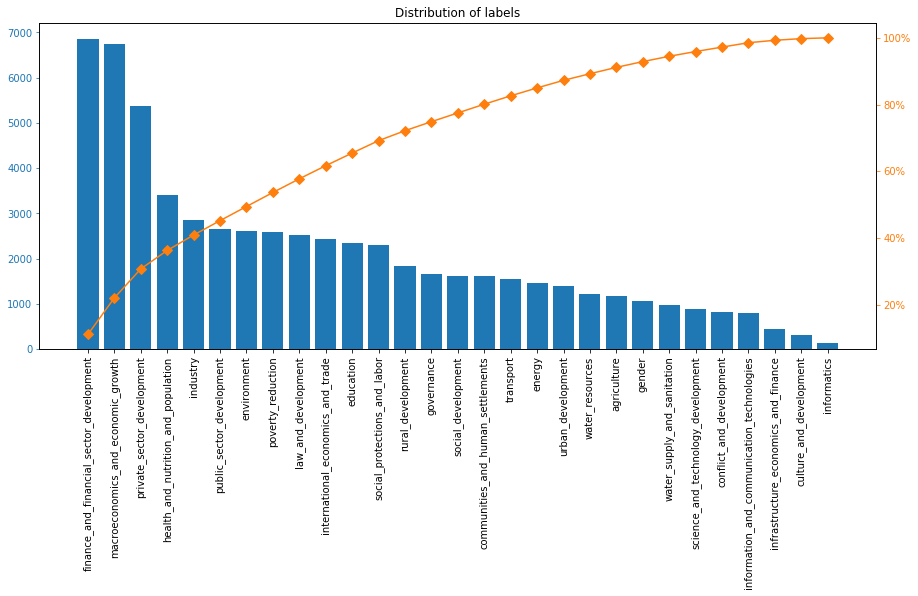

In [7]:
df["cumpercentage"] = df["count"].cumsum()/df["count"].sum()*100

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(df.index, df["count"], color="C0")
ax.tick_params(labelrotation=90)
ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0", labelrotation=0)
ax2.tick_params(axis="y", colors="C1")
plt.title("Distribution of labels")

plt.show()

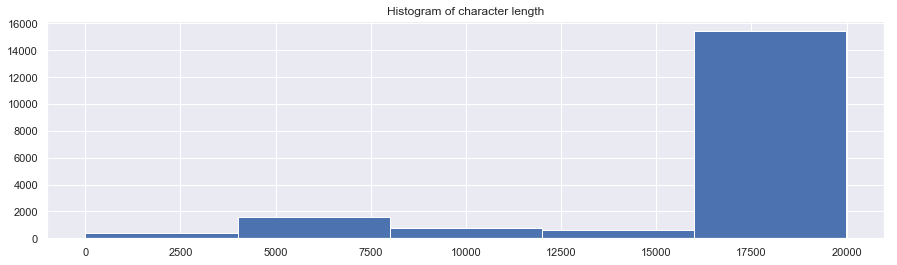

In [8]:
#most documents have greater than 15,000 characters, with a small "bump" in distribution for those in the ~5k range
x['char_length'] = x['doc_text'].apply(lambda x: len(str(x)))
sns.set()
x.char_length.hist(bins=5, figsize=(15,4))
plt.title("Histogram of character length")
plt.show()
x.drop(columns=['char_length'], inplace=True)

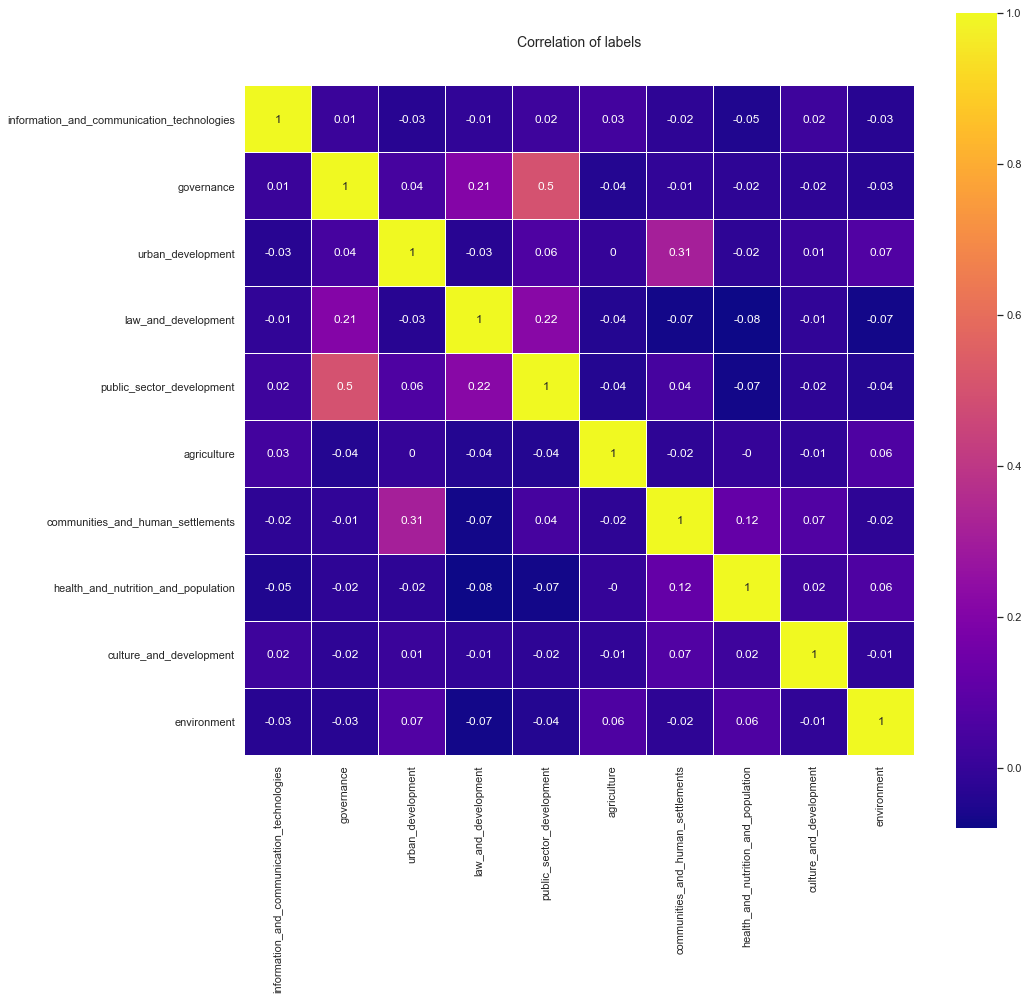

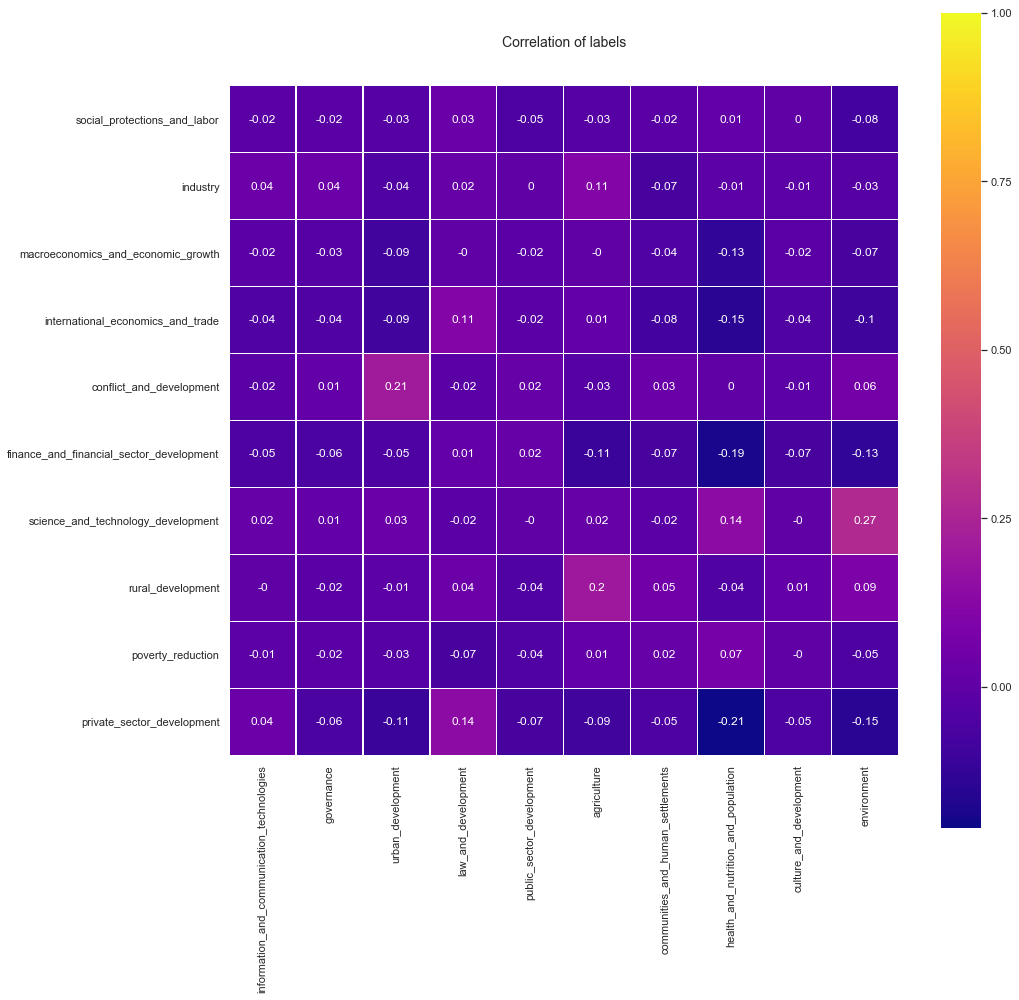

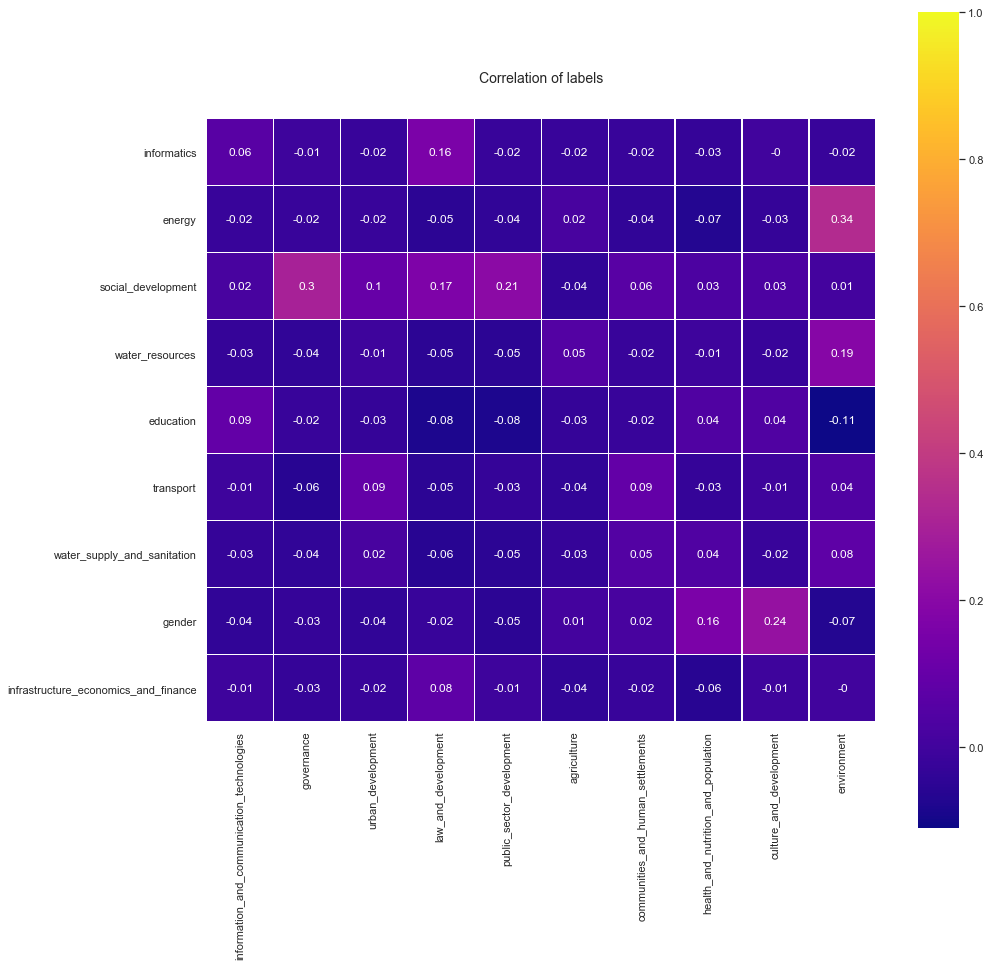

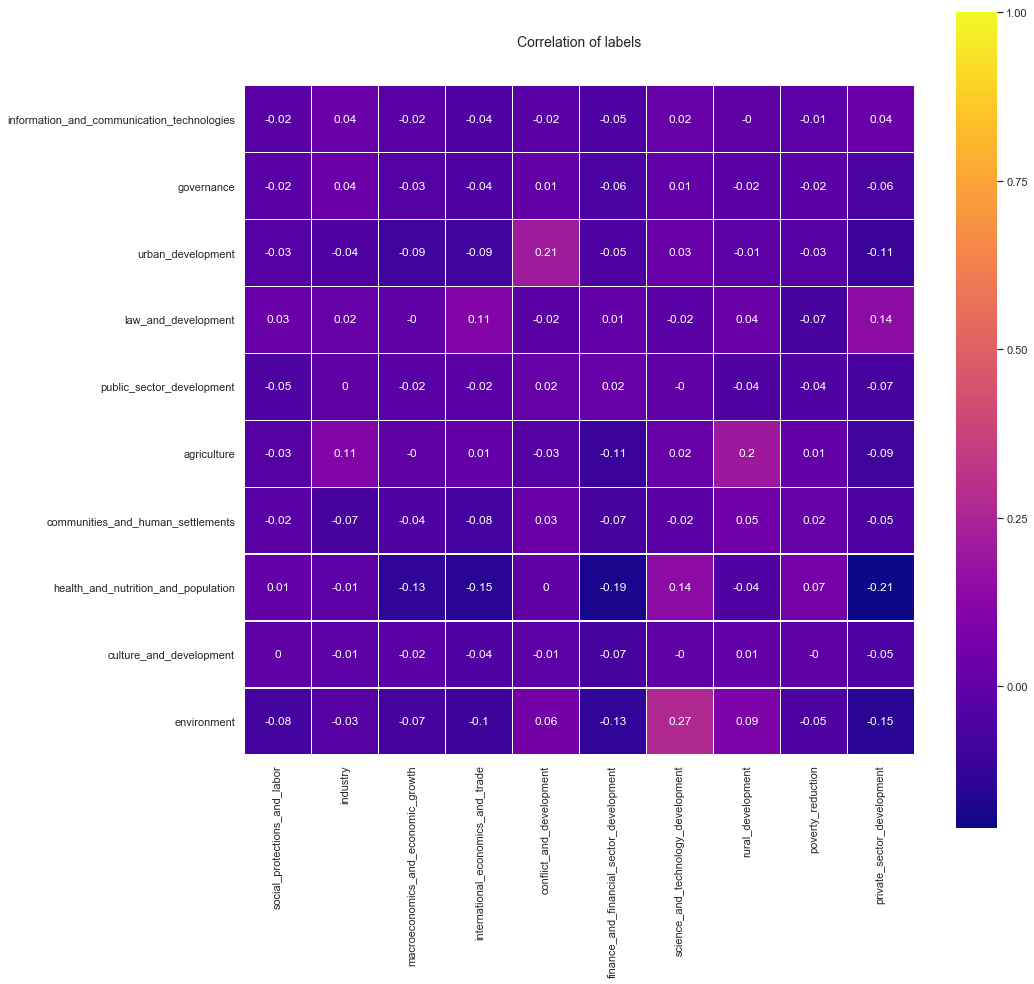

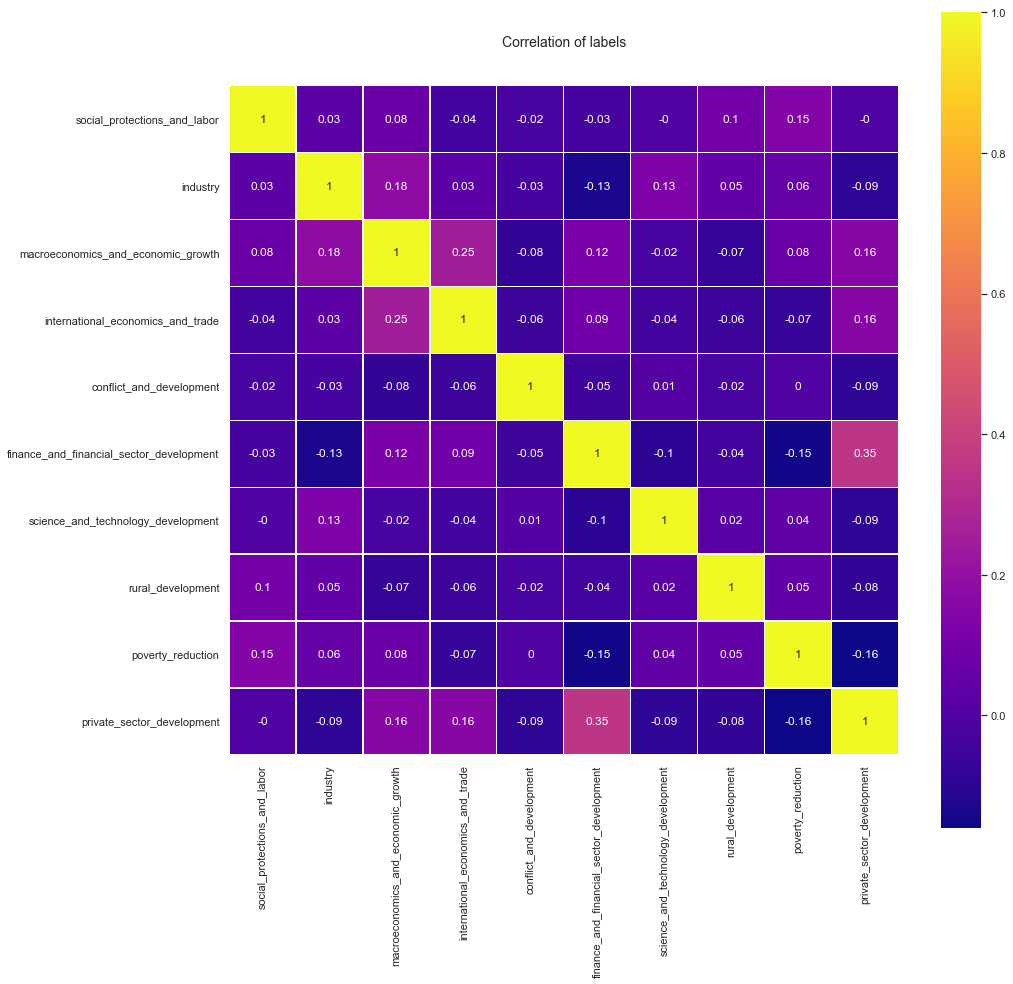

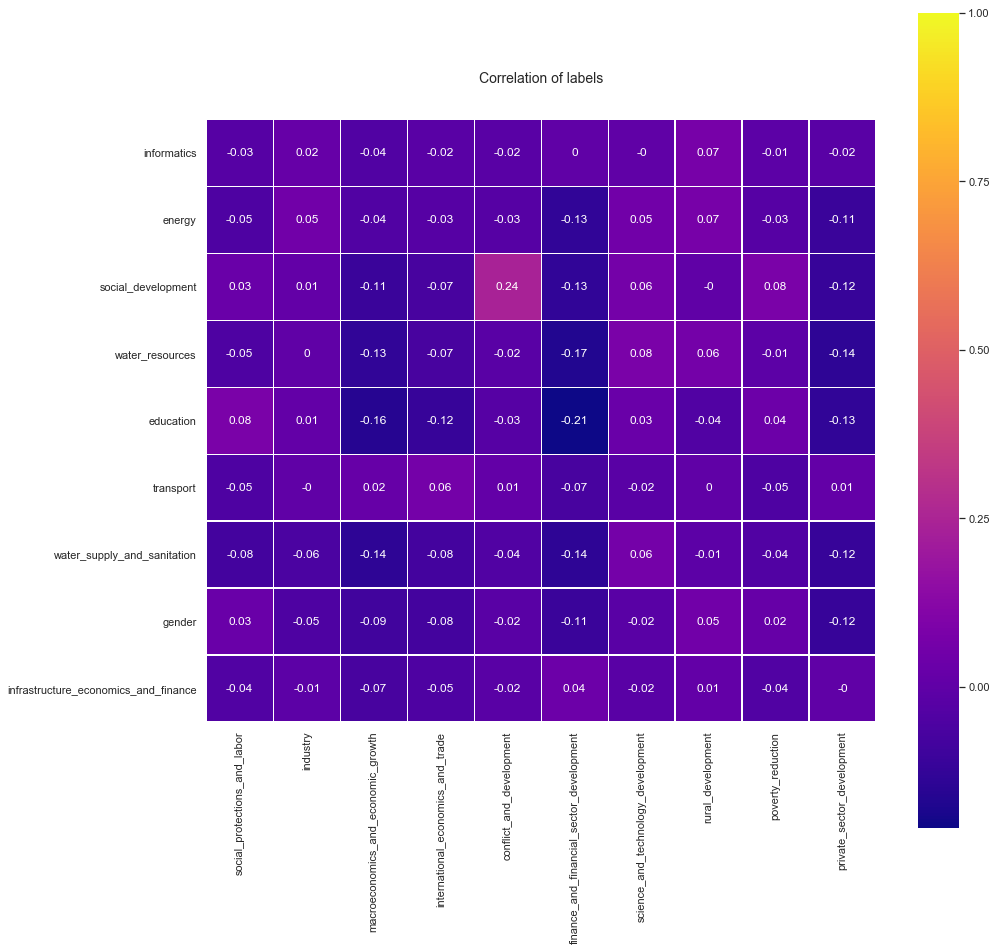

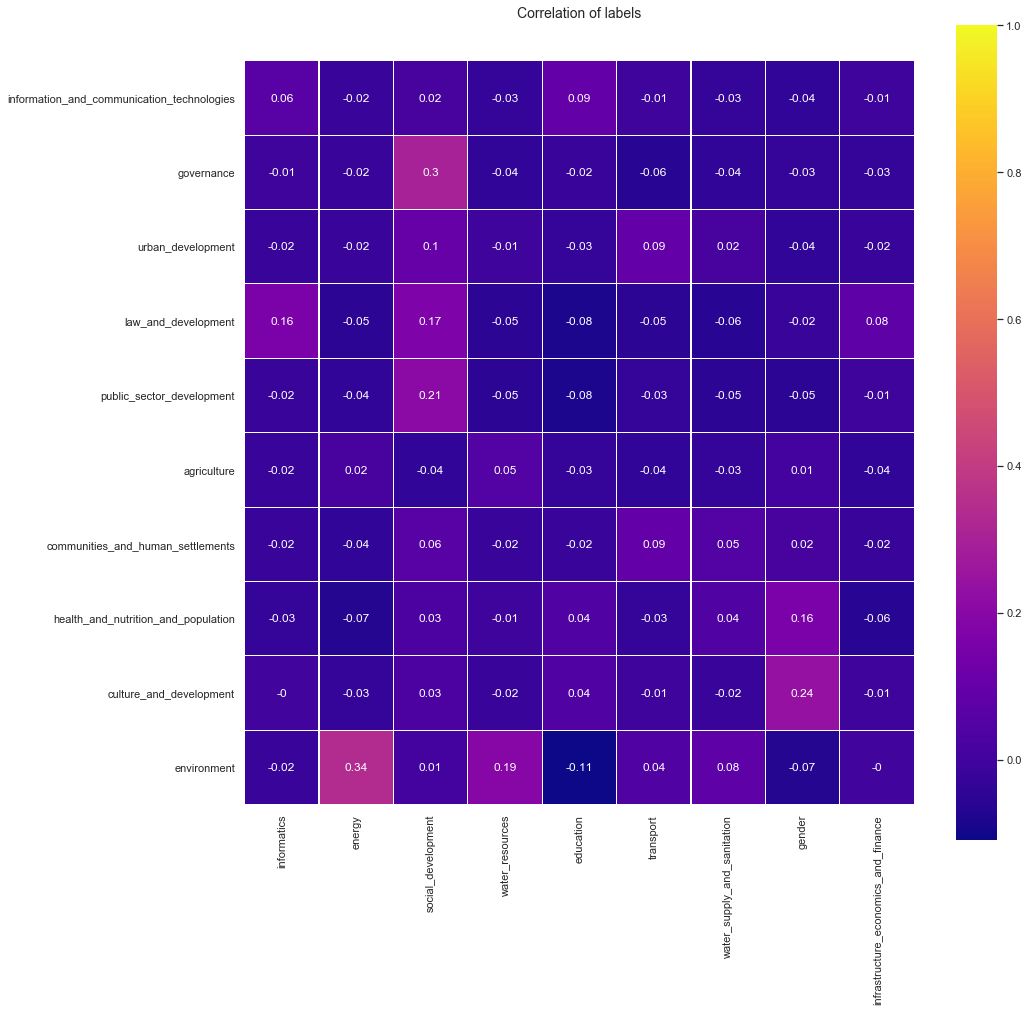

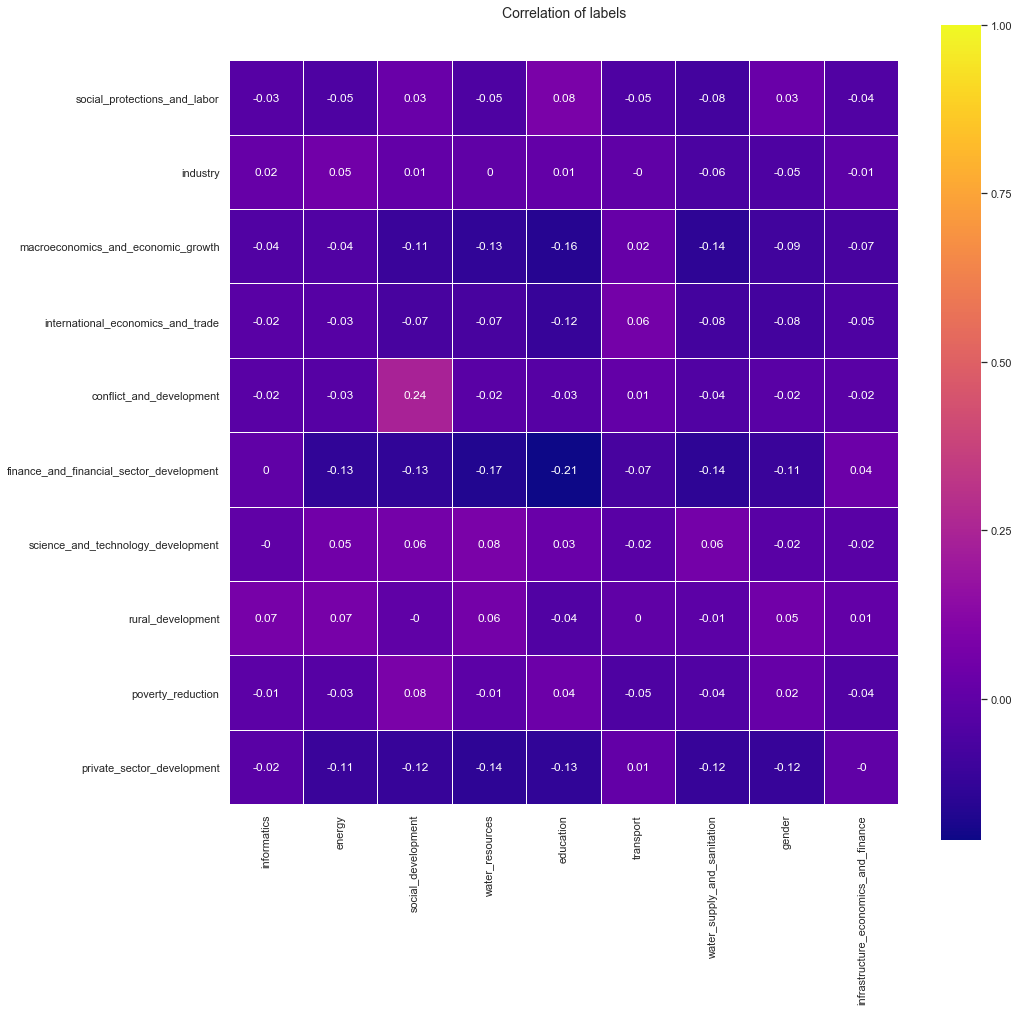

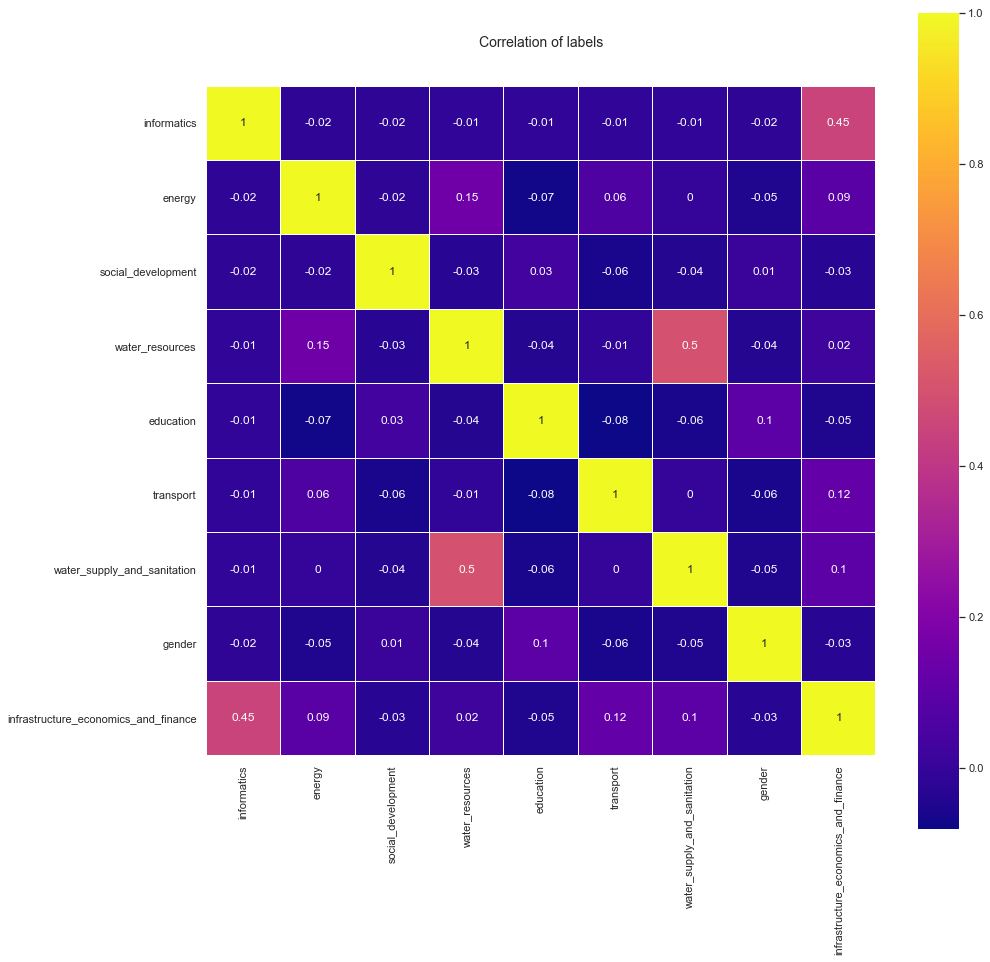

In [29]:
def plotit(cr):
    cr = cr.apply(lambda x: round(x,2))
    colormap = plt.cm.plasma
    plt.figure(figsize=(15,15))
    plt.title('Correlation of labels',y=1.05,size=14)
    sns.heatmap(cr, linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()

cr = y[cols].astype(float).corr()
c1 = cols[:10]
c2 = cols[10:20]
c3 = cols[20:30]

plotit(cr[:10][c1])
plotit(cr[10:20][c1])
plotit(cr[20:30][c1])

plotit(cr[:10][c2])
plotit(cr[10:20][c2])
plotit(cr[20:30][c2])

plotit(cr[:10][c3])
plotit(cr[10:20][c3])
plotit(cr[20:30][c3])

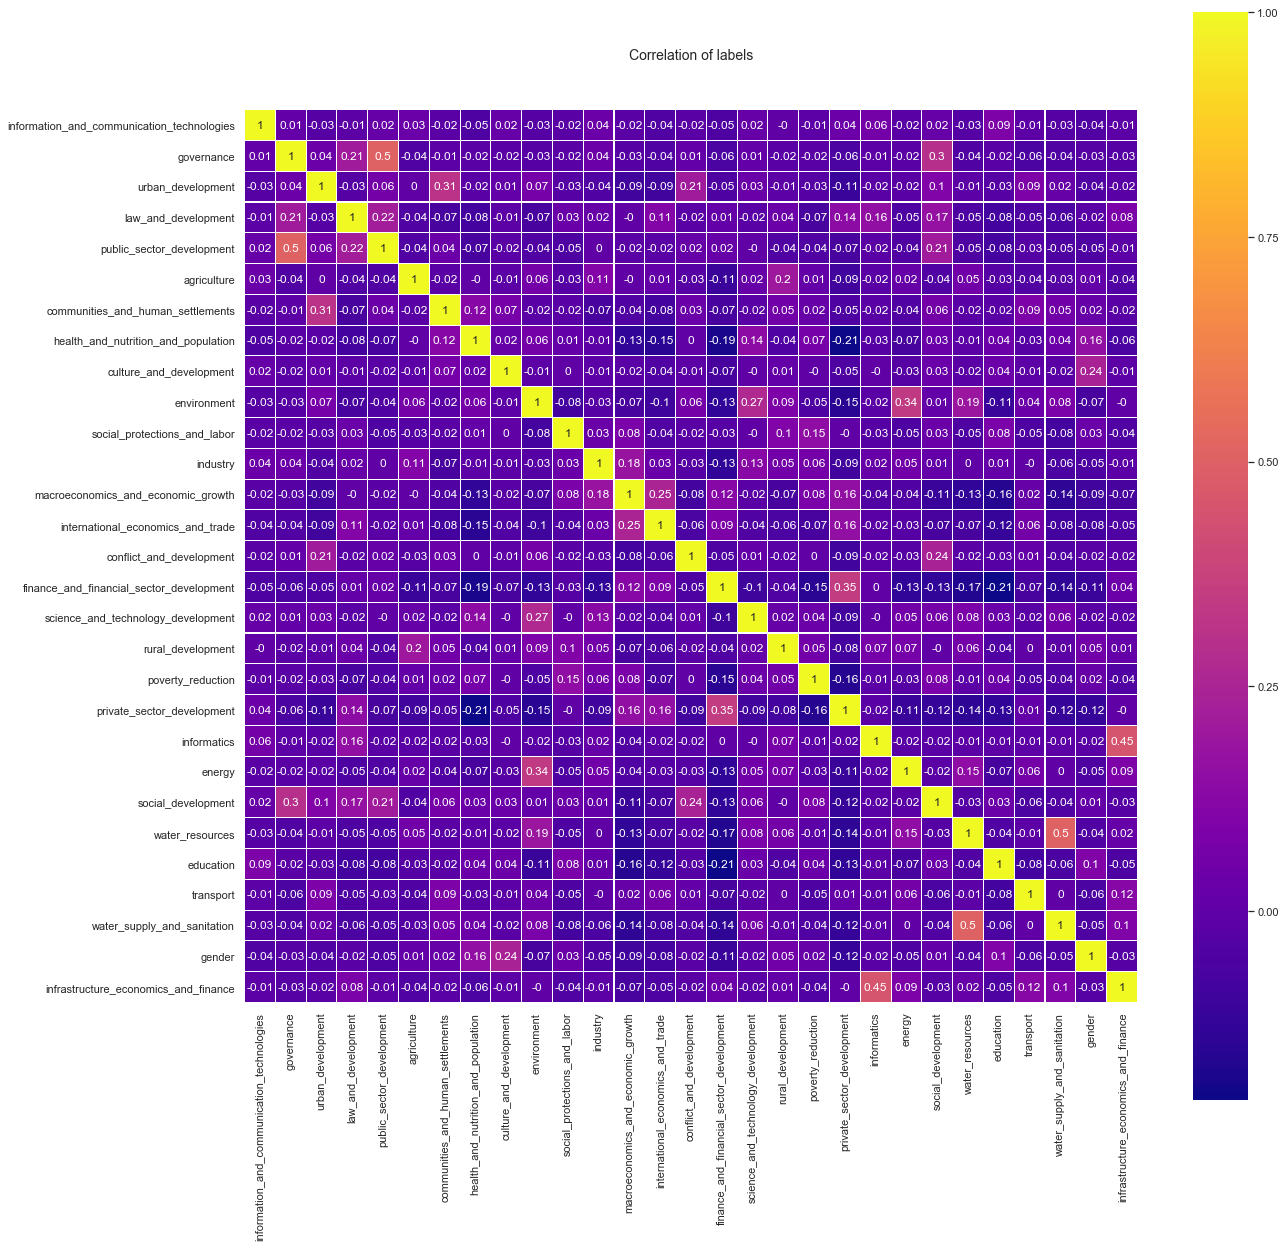

In [115]:
#not a lot of correlation between labels; 'public sector' and 'governance' have a 50% correlation, which makes sense.
cr = y[cols].astype(float).corr()
cr = cr.apply(lambda x: round(x,2))
colormap = plt.cm.plasma
plt.figure(figsize=(20,20))
plt.title('Correlation of labels',y=1.05,size=14)
sns.heatmap(cr, linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [116]:
#word count in document and average length of word has no correlation to the labels
def avg_word(text):
    words = text.split(" ")
    return(sum(len(word) for word in words)/len(words))

cr = y[cols].copy()
cr['word_count'] = x.doc_text.apply(lambda x: len(str(x).split(" ")))
cr['avg_word_len'] = x.doc_text.apply(lambda x: avg_word(x))

cr = cr.astype(float).corr()
cr = cr.apply(lambda x: round(x,2))

cr[['word_count', 'avg_word_len']]

,word_count,avg_word_len
information_and_communication_technologies,-0.02,0.02
governance,-0.01,-0.00
urban_development,-0.02,-0.00
law_and_development,0.02,-0.01
public_sector_development,-0.02,0.02
agriculture,-0.02,0.00
communities_and_human_settlements,-0.03,-0.00
health_and_nutrition_and_population,0.03,0.00
culture_and_development,-0.02,-0.00
environment,-0.00,0.01


In [117]:
#count of numeric 'words' in the document don't seem to correlate to any label
def num_count(text):
    text = re.sub(r'$', '', text)
    words = text.split(" ")
    return len([x for x in words if x.isnumeric()])

cr = y[cols].copy()
cr['number_count'] = x.doc_text.apply(lambda x: num_count(x))

cr = cr.astype(float).corr()
cr = cr.apply(lambda x: round(x,2))

cr['number_count']

information_and_communication_technologies   -0.04
governance                                   -0.03
urban_development                            -0.04
law_and_development                           0.02
public_sector_development                    -0.03
agriculture                                  -0.03
communities_and_human_settlements            -0.04
health_and_nutrition_and_population          -0.05
culture_and_development                      -0.02
environment                                  -0.07
social_protections_and_labor                 -0.01
industry                                     -0.00
macroeconomics_and_economic_growth            0.01
international_economics_and_trade             0.04
conflict_and_development                     -0.02
finance_and_financial_sector_development      0.10
science_and_technology_development           -0.02
rural_development                            -0.01
poverty_reduction                            -0.04
private_sector_development     

In [35]:
train_comments = x['doc_text'].values
test_comments = test['doc_text'].values
train_comments_lengths = [len(c) for c in train_comments]
test_comments_lengths = [len(c) for c in test_comments]

def explore_comments(arr):
    print("Max-length:", np.max(arr))
    print("Avg-length:", np.average(arr))
    print("Min-length:", np.min(arr))
    print("Standard division", np.std(arr))
    print("Range", np.min(arr), np.average(arr) + 2 * np.std(arr))

print("---Train---")
explore_comments(train_comments_lengths)

print("---Test---")
explore_comments(test_comments_lengths) # select 27000 for Char RNN I guess

---Train---
Max-length: 19993
Avg-length: 17424.496335634627
Min-length: 6
Standard division 4820.295470343612
Range 6 27065.08727632185
---Test---
Max-length: 19994
Avg-length: 17448.96872178854
Min-length: 4
Standard division 4817.016083338225
Range 4 27083.00088846499


In [11]:
#contineu EDA with pre-processed data
import pickle
train = pickle.load(open('../data/train_preprocessed.pkl','rb'))
test = pickle.load(open('../data/test_preprocessed.pkl','rb'))
labels = pickle.load(open('../data/labels_preprocessed.pkl','rb'))

In [12]:
def get_col_list(rowid):
    tlist = []
    for _col in labels.columns:
        if labels.loc[rowid][_col] == 1:
            tlist.extend([_col])
    return tlist

train = train.reset_index()
train['labels_combined'] = train.row_id.map(lambda x: get_col_list(x))
train = train.set_index('row_id')

In [13]:
train.head()

,doc_text,labels_combined
row_id,,
0,information visit taking stock ecb unveiled tr...,"[governance, law_and_development, public_secto..."
1,ifc thoughtleadership note january importance ...,"[urban_development, public_sector_development,..."
2,wps policy research working paper determinant ...,"[health_and_nutrition_and_population, macroeco..."
3,procurement monitoring social accountability c...,"[governance, law_and_development, public_secto..."
4,executive board meeting minute meeting october...,"[governance, public_sector_development]"


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train.labels_combined)
Y = multilabel_binarizer.transform(train.labels_combined)
'''
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(train.doc_text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)'''
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3), min_df=9e-4)
X_tfidf = tfidf_vectorizer.fit_transform(train.doc_text)

In [34]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)

In [38]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, 
        Y_tfidf_resampled, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'class distribution in training set after resampling')

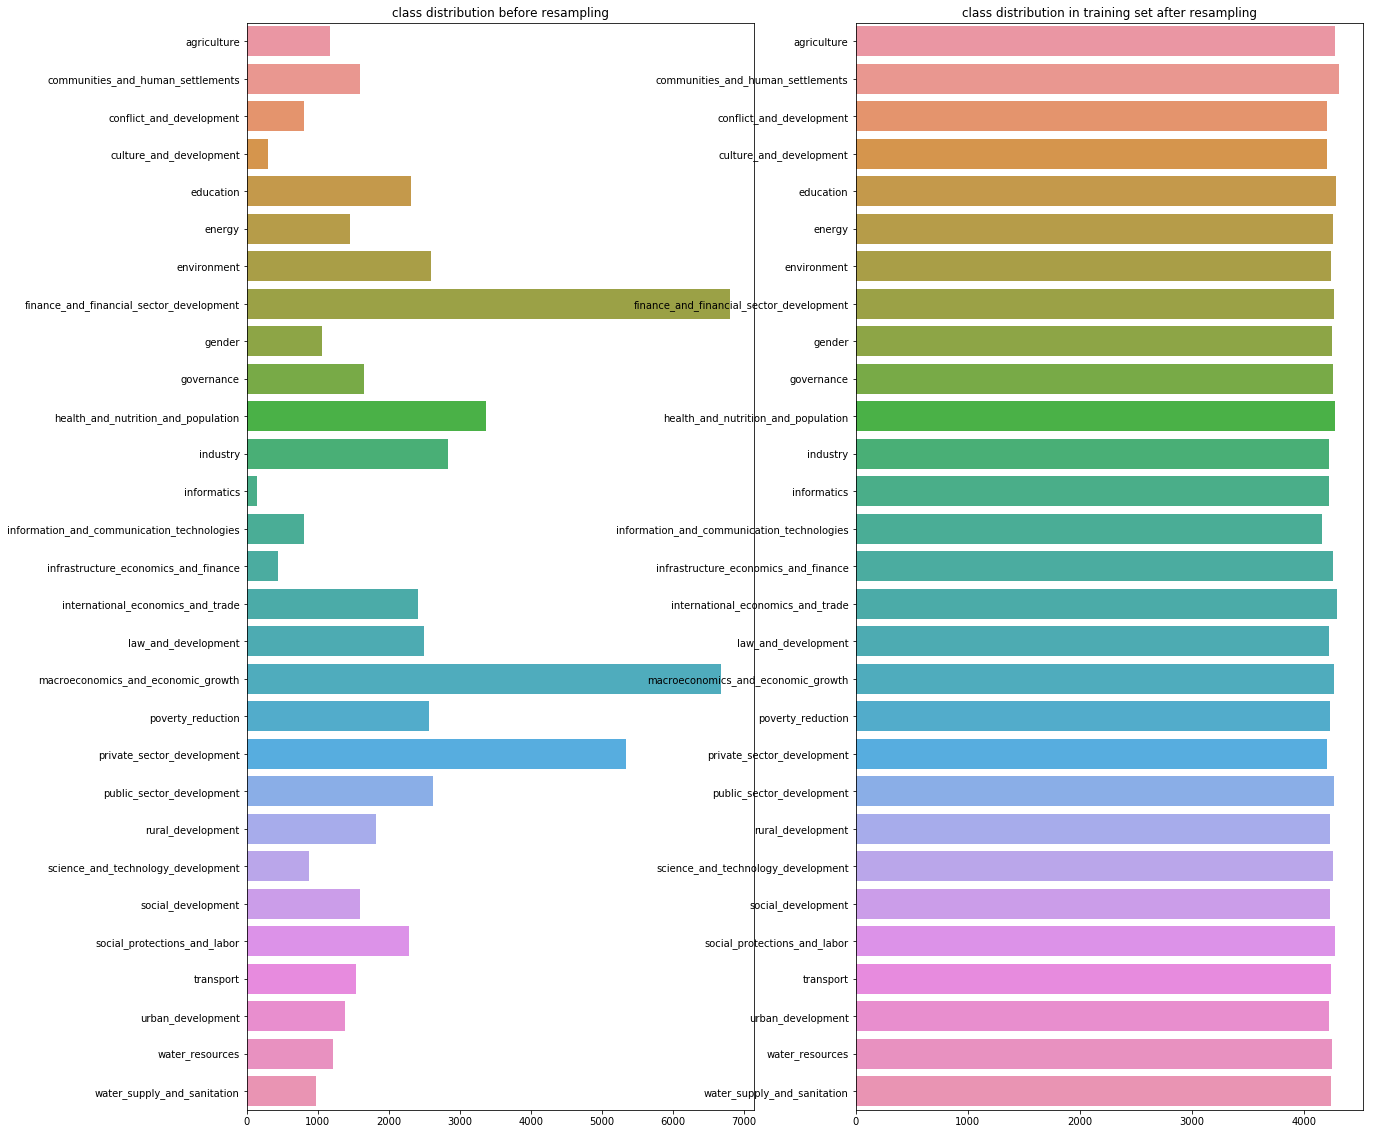

In [39]:
fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=Y.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_test)
g2 = sns.barplot(x=y_train_tfidf.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score, precision_score, recall_score


def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def GetMicroAccuracy(labels, predictions):
    predictions = np.where(predictions >= 0.5, 1, 0)
    _val_f1 = f1_score(labels, predictions, average='micro')
    _val_recall = recall_score(labels, predictions, average='micro')
    _val_precision = precision_score(labels, predictions, average='micro')
    return _val_f1, _val_precision, _val_recall
    
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("[Weighted] F1 Score: %f,  Precision: %f,  Recall: %f" % GetMicroAccuracy(y_test_tfidf, y_pred))
    #print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    #print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))

    print("---")  

In [43]:
#nb_clf = MultinomialNB()
#sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=None)
lr1 = LogisticRegression(solver='liblinear')
lr2 = LogisticRegression(solver='lbfgs',n_jobs=-1)
#mn = MultinomialNB()

for classifier in [lr1,lr2]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

Clf:  LogisticRegression
[Weighted] F1 Score: 0.825231,  Precision: 0.943952,  Recall: 0.733037
---
Clf:  LogisticRegression
[Weighted] F1 Score: 0.825298,  Precision: 0.944073,  Recall: 0.733069
---


In [51]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=9e-5)
X_tfidf = tfidf_vectorizer.fit_transform(train.doc_text)

ros = RandomOverSampler(random_state=42)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)

In [53]:
print(X_tfidf_resampled.shape, Y_tfidf_resampled.shape)

(153932, 3201797) (153932, 29)


In [54]:
#predict using LR / liblinear
lr = LogisticRegression(solver='liblinear')
clf = OneVsRestClassifier(lr)
clf.fit(X_tfidf_resampled, Y_tfidf_resampled)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [56]:
#re-run this to get the proba values first
x_test_tfidf = tfidf_vectorizer.transform(test.doc_text)
predictions = clf.predict(x_test_tfidf)

In [57]:
orig_cols = labels.columns.tolist()
pred_cols = list(multilabel_binarizer.classes_)

sub = test.copy()
sub.drop(columns=['doc_text'], inplace=True)
for _col in multilabel_binarizer.classes_:
    sub[_col] = np.uint8(0)
#rearrange the order for prediction output, then load the predictions
sub = sub[pred_cols]
sub[:] = predictions
#rearrange back into the submission order and to concat with out TEST_OUT 
sub = sub[orig_cols]

In [58]:
for label in sub.columns:
    pltme = pd.Series(sub[label].values, name=label)
    in_group = np.where(pltme >= 0.5, 1, 0).sum()
    print('Total for "%s" is %s' % (label, in_group))

Total for "information_and_communication_technologies" is 46
Total for "governance" is 300
Total for "urban_development" is 19
Total for "law_and_development" is 108
Total for "public_sector_development" is 26
Total for "agriculture" is 616
Total for "communities_and_human_settlements" is 651
Total for "health_and_nutrition_and_population" is 526
Total for "culture_and_development" is 116
Total for "environment" is 374
Total for "social_protections_and_labor" is 6
Total for "industry" is 192
Total for "macroeconomics_and_economic_growth" is 85
Total for "international_economics_and_trade" is 556
Total for "conflict_and_development" is 397
Total for "finance_and_financial_sector_development" is 2777
Total for "science_and_technology_development" is 0
Total for "rural_development" is 14
Total for "poverty_reduction" is 98
Total for "private_sector_development" is 108
Total for "informatics" is 9
Total for "energy" is 781
Total for "social_development" is 27
Total for "water_resources" is

In [60]:
#show if there are any rows that have NO prediction
xxx = sub.copy()
xxx[:] = np.where(xxx[:].values >= 0.5, 1, 0).astype(np.uint8)
xxx = pd.DataFrame(xxx.sum(axis=1))
xxx.columns = ['cnt']
msg_idx = xxx[(xxx.cnt < 1)].index.values
sub[(sub.index.isin(msg_idx))]
xxx[(xxx.cnt == 0)]

,cnt
row_id,
0,0
8,0
11,0
14,0
15,0
17,0
20,0
21,0
22,0


In [ ]:
test_pre_pred = pickle.load(open('../data/test_predicted.pkl','rb'))

#save the probability distributions for our future stacking
sub = pd.concat([sub,test_pre_pred]).sort_values(by='row_id')
sub.to_csv('../submissions/proba/TFIDF-LR_unlimited_3gram_OverSample_OvR.csv')

#convert to 1 / 0 output and save for submission
sub[:] = np.where(sub[:].values >= 0.5, 1, 0).astype(np.uint8)
sub.to_csv('../submissions/TFIDF-LR_unlimited_3gram_OverSample_OvR.csv')